# Reservoir Fluid Clustering for Compartmentalization Detection
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Oil & Gas PVT Analytics

## Objective
To identify distinct reservoir compartments by clustering fluid samples based on their Equation of State (EOS) compositional components.

## Methodology
1. **Data Loading**: Import compositional data (Mole fractions).
2. **Preprocessing**: Standardize the data to handle different scales of components (e.g., $C_1$ vs $C_{7+}$).
3. **Dimensionality Reduction**: Use PCA to visualize high-dimensional compositional data in 2D.
4. **Clustering**: Apply K-Means to find flow units.
5. **Validation**: Determine the optimal number of clusters using the Elbow Method.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Configure plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Data Loading
We will load the dataset containing 250 fluid samples. The features of interest are the mole fractions from Nitrogen ($N_2$) through Heptane-plus ($C_{7+}$).

In [2]:
# Load dataset
df = pd.read_csv('fluid_samples.csv')

# Define features (Compositional columns)
features = ['N2', 'CO2', 'C1', 'C2', 'C3', 'iC4', 'nC4', 'iC5', 'nC5', 'C6', 'C7+']

print(f"Data Shape: {df.shape}")
df.head()

Data Shape: (250, 14)


,Well_ID,Depth_m,N2,CO2,C1,C2,C3,iC4,nC4,iC5,nC5,C6,C7+,True_Compartment
0,Well-A-41,2576.102790,0.020829,0.010328,0.743083,0.082534,0.050327,0.020947,0.020822,0.010141,0.010229,0.010116,0.020644,Block_North
1,Well-B-02,2830.196816,0.009869,0.019109,0.554550,0.097837,0.080150,0.039468,0.039557,0.029734,0.029663,0.039703,0.060362,Block_Central
2,Well-C-09,3103.046369,0.010121,0.009769,0.357165,0.049909,0.050655,0.029348,0.029059,0.040642,0.040289,0.088349,0.294693,Block_South
3,Well-B-79,2926.888216,0.010065,0.019714,0.562505,0.098408,0.077705,0.038218,0.037990,0.028622,0.029716,0.039812,0.057247,Block_Central
4,Well-B-47,2809.368639,0.009727,0.019892,0.554071,0.098347,0.079130,0.040661,0.039512,0.031026,0.029825,0.037937,0.059872,Block_Central


## Exploratory Data Analysis (EDA)
Before clustering, it is essential to look at the correlations between components. For example, lighter components ($C_1$) often inversely correlate with heavier components ($C_{7+}$).

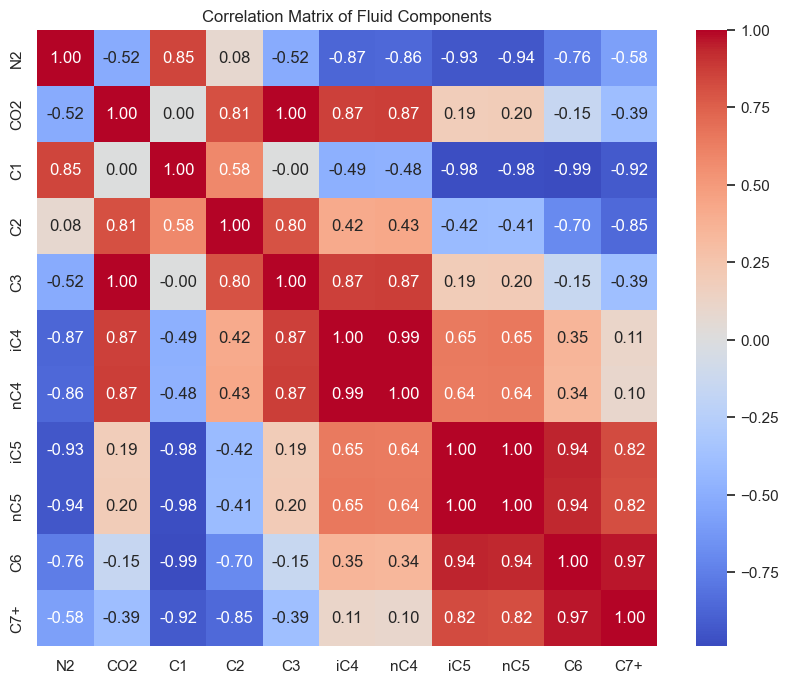

In [3]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Fluid Components")
plt.show()

## Data Preprocessing
### Standardization
Clustering algorithms based on distance (like K-Means) are sensitive to the scale of data. While mole fractions sum to 1, the variance of Methane ($C_1$) is much larger than trace elements like $iC_5$. We use `StandardScaler` to transform features to have a mean of 0 and variance of 1.

$$z = \frac{x - \mu}{\sigma}$$

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Convert back to DataFrame for viewing
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df.describe().round(2)

,N2,CO2,C1,C2,C3,iC4,nC4,iC5,nC5,C6,C7+
count,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00
mean,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.78,-0.86,-1.31,-1.49,-0.92,-1.38,-1.37,-1.41,-1.42,-1.14,-0.86
25%,-0.70,-0.76,-1.23,-1.30,-0.77,-1.23,-1.21,-1.35,-1.36,-1.11,-0.85
50%,-0.66,-0.71,0.01,0.13,-0.70,-0.03,-0.04,0.26,0.26,-0.21,-0.53
75%,1.38,1.27,1.23,1.01,1.26,1.09,1.09,1.02,1.03,1.30,1.41
max,1.68,1.58,1.30,1.30,1.67,1.45,1.42,1.27,1.22,1.48,1.52


## Determining Optimal Clusters (K)
We use the **Elbow Method** to calculate the Within-Cluster Sum of Squares (Inertia) for different values of $K$. We look for the "elbow" point where adding more clusters yields diminishing returns in reducing inertia.

/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklear

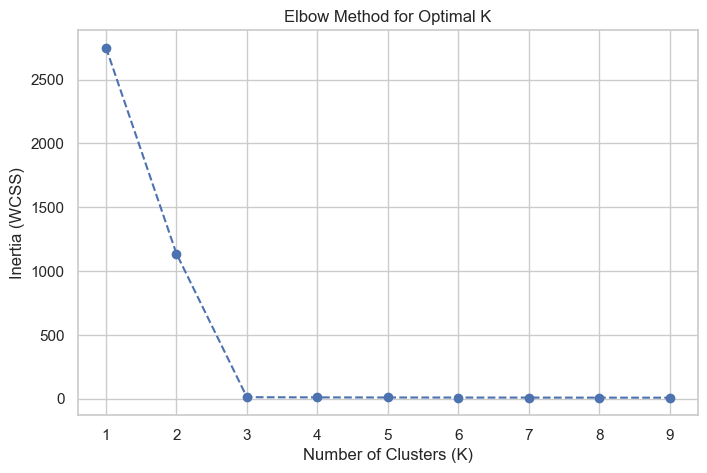

In [5]:
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.show()

## Applying K-Means
Based on the Elbow plot above (which should show a break around K=3), we will apply K-Means with 3 clusters.

In [6]:
# Apply K-Means with K=3 (Adjust based on Elbow plot observation)
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['Cluster_Label'] = clusters

print("Samples per cluster:")
print(df['Cluster_Label'].value_counts())

Samples per cluster:
Cluster_Label
1    90
0    80
2    80
Name: count, dtype: int64


/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


## Visualization with PCA
Since our data has 11 dimensions (components), we cannot visualize it directly. We use **Principal Component Analysis (PCA)** to reduce the data to 2 principal components, capturing the maximum variance, to visualize how well the clusters are separated.

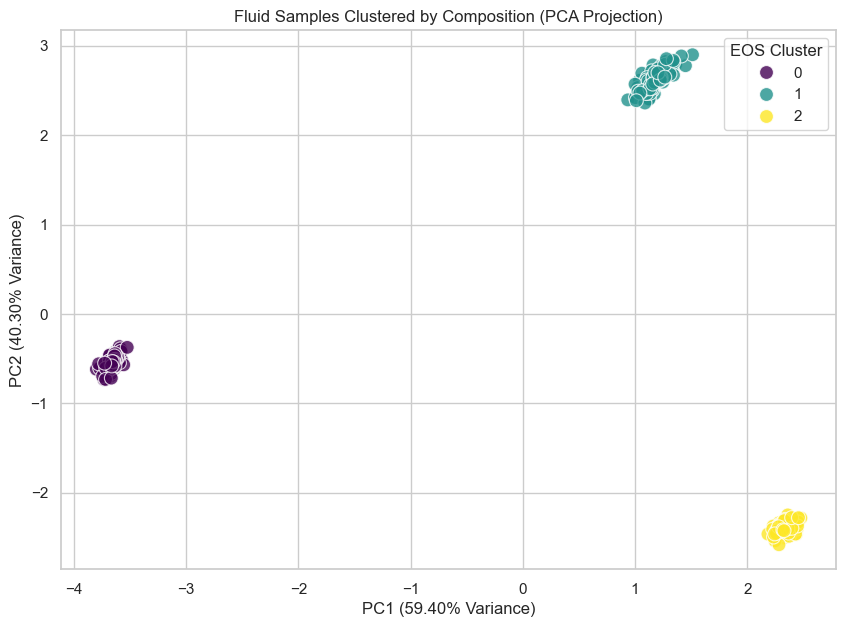

In [7]:
# Reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df['Cluster_Label']

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis', s=100, alpha=0.8)
plt.title('Fluid Samples Clustered by Composition (PCA Projection)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Variance)')
plt.legend(title='EOS Cluster')
plt.show()

## Result Interpretation
Let's inspect the average composition of each cluster to understand the physical meaning (e.g., is Cluster 0 a Gas Cap and Cluster 1 a Black Oil?).

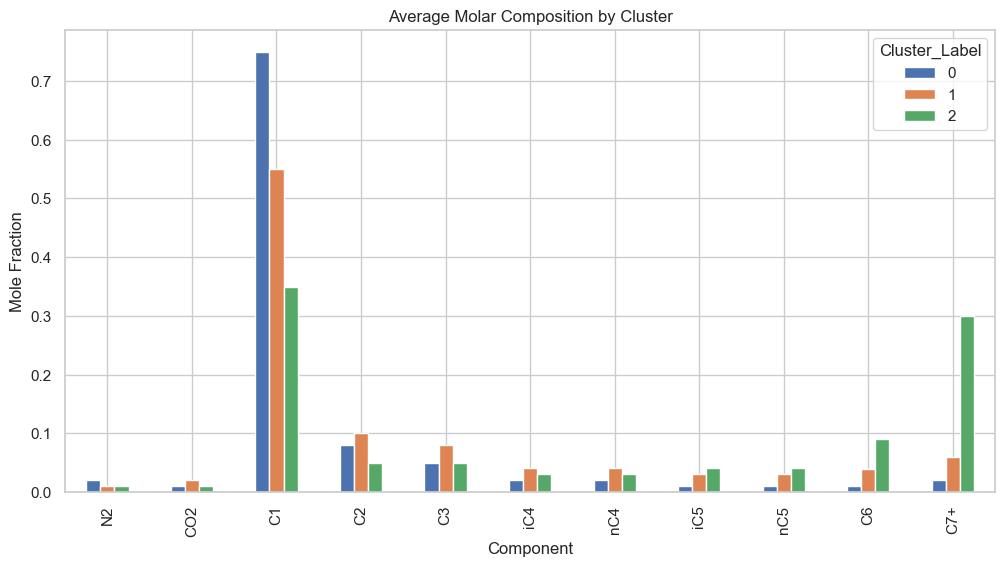

,N2,CO2,C1,C2,C3,iC4,nC4,iC5,nC5,C6,C7+
Cluster_Label,,,,,,,,,,,
0,0.020102,0.009996,0.749754,0.080059,0.049971,0.020029,0.020009,0.009999,0.009980,0.010047,0.020055
1,0.009975,0.019945,0.550697,0.099734,0.079918,0.040005,0.040049,0.029952,0.030038,0.039811,0.059876
2,0.010045,0.009984,0.349106,0.050027,0.050112,0.030157,0.029969,0.040102,0.039977,0.090204,0.300316


In [8]:
# Group by Cluster and calculate mean composition
cluster_profile = df.groupby('Cluster_Label')[features].mean()

# Plotting the profiles
cluster_profile.T.plot(kind='bar', figsize=(12, 6))
plt.title("Average Molar Composition by Cluster")
plt.ylabel("Mole Fraction")
plt.xlabel("Component")
plt.show()

# Display the numerical profile
display(cluster_profile)

## Conclusion & Reservoir Implications

The unsupervised learning analysis (K-Means on EOS components) has successfully identified **three distinct reservoir compartments**. The clear separation in the PCA plot confirms that these fluids have not equilibrated, suggesting the presence of sealing barriers between the well groups.

### Cluster Characterization
Based on the compositional analysis:

1.  **Cluster 0 (Gas Cap / Retrograde Gas):**
    * **Composition:** Dominant Methane ($C_1 > 70\%$) and negligible Heavies ($C_{7+} \approx 0\%$).
    * **Implication:** High compressibility fluid. Production strategy should focus on gas handling or cycling to prevent retrograde condensation.

2.  **Cluster 1 (Volatile Oil):**
    * **Composition:** Balanced profile with $C_1 \approx 55\%$ and the highest fraction of intermediates ($C_2-C_6$).
    * **Implication:** Likely a high-shrinkage oil. Surface facilities must be designed to handle significant gas breakout.

3.  **Cluster 2 (Black Oil / Heavy Oil):**
    * **Composition:** Lowest Methane ($C_1 \approx 35\%$) and massive Heavy fraction ($C_{7+} \approx 30\%$).
    * **Implication:** Low solution gas and higher viscosity. This compartment will likely require artificial lift (Rod Pumps or ESPs) much earlier than the others.

### Recommendation
The static geological model should be updated to include flow barriers separating the wells in Cluster 0, 1, and 2.